In [1]:
# General
import xarray as xr    # handles netcdf data
import numpy as np     # numerical functions etc
import pandas as pd    # dataframes
import matplotlib      # plotting functions
import matplotlib.pyplot as plt    # specific plotting function I use a lot   
from matplotlib.patches import Rectangle     # specific plotting function with an annoyingly long name
import matplotlib.gridspec as gridspec #to define the sizes of plots specifically
import geopandas as gpd    # shapefiles
import cartopy     # plotting geographical features
from shapely.geometry import MultiPolygon, Polygon #to deal with 3D polygons
import regionmask    # convert shapefile to binary 0,1 mask
import re     # regular expressions (replace substrings etc)
from geopy.geocoders import Nominatim    # get lat & lon coordinates from a place name

#for climate indices
import xclim.indices as xc_i
import xclim as xc

#For plotting
import matplotlib.ticker as plticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import nc_time_axis #to plot cf.time axis
import cftime #to plot cf.time axis

#For Statistics
import scipy.stats as stats
from scipy import optimize
from xclim.indices.stats import fit
from scipy.stats import norm, gamma
import lmoments3.distr                     # conda activate xclim; pip install git+https://github.com/OpenHydrology/lmoments3.git
glo = getattr(lmoments3.distr, "glo")

#For copulas
import sklarpy.univariate as sk_uni
from sklarpy.copulas import gh_copula
from sklarpy.multivariate import mvt_normal
from sklarpy.copulas import MarginalFitter
from sklarpy.univariate import UnivariateFitter
from sklarpy import print_full
from sklarpy.copulas import gumbel_copula
from sklarpy.copulas import frank_copula
from sklarpy.copulas import clayton_copula

#For handling errors
import sys
import warnings

## Necessary Functions:

In [2]:
def new_get_nSPEI(eff_pr, months = range(1,13), calibration_period = slice("1980", "2010")):
    '''
    Summary:
    -----------
    Computes a the monthly SPEI value. 
    
    Parameters:
    -----------
    eff_pr: xarray DataArray object 
            - Effective Precipitation / Water Balance, defined via Precipitation - Potential Evapotranspiration
            - must be a DataArray with a time dimension labelled as a DateTime object
         
    months: range object
            - describing the months of the year for which the SPEI value should be calculated
             
    calibration_period: slice object
            - describing the calibration timeperiod, needs to be within the dataset
         
    Returns:
    ----------
    spei: xarray DataArray oject
            - The SPEI values              
    '''

    ## NB CURRENTLY NOTHING IN PLACE TO HANDLE DRY PERIODS IN THE TIME SERIES - USE WITH CAUTION!
    
    # create empty list to hold results
    spei_monthly = []
    # fit each calendar month in turn
    for m in months:    
        # select current calendar month
        epr_m = eff_pr.sel(time = eff_pr.time.dt.month == m)     
        # estimate parameters over calibration period (PWM seems to give more robust fit, so using xclim fit method - also applies over whole spatial array)
        epr_cal = epr_m.sel(time = calibration_period).copy()    
        # fit parameters for whole map (has to be done manually due to bug in xclim)
        pars = xr.apply_ufunc(lambda x : np.asarray(list(glo.lmom_fit(x.copy()).values())), epr_cal,
                              input_core_dims = [["time"]], output_core_dims = [["dparams"]], vectorize = True).assign_coords(dparams = ["k", "loc", "scale"])    
        # running without dry-month normalisation for now - check if needed for this dataset
        spei_m = xr.apply_ufunc(lambda pr, dparams : norm.ppf(glo.cdf(pr, *dparams)), epr_m, pars, 
                                input_core_dims=[["time"],["dparams"]], output_core_dims=[["time"]], vectorize = True).assign_coords(time = epr_m.time)
        # replace +ve (-ve) infinite values with finite maximum (minimum) in each grid cell
        spei_finite = xr.concat([spei_m.where(~np.isinf(spei_m)), 
                                 xr.ones_like(spei_m).where(spei_m == np.inf) * spei_m.where(spei_m < np.inf).max("time"),
                                 xr.ones_like(spei_m).where(spei_m == -np.inf) * spei_m.where(spei_m > -np.inf).min("time")], "new").sum("new").copy()
        spei_monthly.append(spei_finite) 

    # concatenate monthly fitted values, reorder & relabel
    spei = xr.concat(spei_monthly, "time").sortby("time").rename("spei")  
    # clean out existing attributes and replace with new variable description
    for k in list(spei.attrs.keys()): del spei.attrs[k]
    spei = spei.assign_attrs(notes = "Calibrated against "+str(calibration_period.start)+"-"+str(calibration_period.stop))
    spei = spei.where(~np.isnan(eff_pr)).dropna("time", "all")
    
    # Replace exactly zero values with linear interpolation as these are fit-failures
    zero_mask = (spei == 0)
    spei_zero_filled = spei.where(~zero_mask)  # keep non-zero values as they are
    spei_interpolated = spei_zero_filled.interpolate_na(dim="time", method="linear")
    
    # Combine the interpolated values back into the original array, but only for positions where spei was zero
    spei = xr.where(zero_mask, spei_interpolated, spei)

    return spei

def get_SPEI_Duration_and_Severity_RunTheory(spei,threshold_drought=-0.8,threshold_minor=-1.5,threshold_combining=1):
    '''
    Summary:
    -----------
    Function which calculates the Severity-Duration pairs for a given SPEI timeseries. 
    
    Parameters:
    -----------
    spei: xarray DataArray oject
            - Timeseries containing the spei values
            
    threshold_drought: float 
            - Threshold representing the onset of a drought event
         
    threshold_minor: float 
            - Threshold representing the minium spei value for a 1-month event to be considered a drought
    
    threshold_combining: float 
            - Threshold representing the minium spei value which needs to be exceeded that two drought events which
            are separated by only one month to be considered individual events
         
    Returns:
    ----------
    Duration: Array
            - Values representing the Duration of the Drought events      
        
    Severity: Array
            - Values representing the Severity of the Drought events   
    '''
    
    #Set-up Array
    duration=[]
    severity=[]
    
    D=0
    S=0
    for t in np.arange(0,len(spei),1):
        #Drought Condition
        if spei[t]<threshold_drought:
            D=D+1
            S=S+spei[t]
            
        #To take the case into account if last value is just one month -> ongoing heatwave, 
        #only when last severity is lower than threshold_combining and severity of event larger than threshold_minor!
        elif spei[t-1]<threshold_drought and t==len(spei)-1 and spei[t]<threshold_combining and spei[t] < threshold_minor:
            D=D+1
            S=S
            
        #The condition before corrected for the last loop
        elif t!=len(spei)-1 and spei[t-1]<threshold_drought and spei[t+1]<threshold_drought and spei[t]<threshold_combining:
            D=D+1
            S=S
        
        #If the spei value is above the threshold and none of the conditions above apply that drought event is over
        else:
            duration.append(D )
            D=0
            severity.append(S)
            S=0

    #to get values if the drought ends in the loop
    duration.append(D)
    severity.append(S)
    
    #remove all durations of 1 if Severity is less than threshold (here set to: -1.5) 
    for i in np.arange(0,len(duration),1):
        if duration[i] == 1:
            if severity[i] > threshold_minor:
                duration[i] = 0
                severity[i] = 0
                
    #Remove all 0 and define severity positive
    duration = np.array(duration)
    duration = duration[duration>0]
    
    severity = np.array(severity)
    severity = -severity
    severity = severity[severity>0]      
    
    return duration, severity

def get_SPEIandTime_Duration_and_Severity_RunTheory(spei,time,threshold_drought=-0.8,threshold_minor=-1.5,threshold_combining=1):
    '''
    Summary:
    -----------
    Adapted function which calculates the Severity-Duration pairs for a given SPEI timeseries which also returns the onset 
    and end of the drought event
    
    Parameters:
    -----------
    spei: xarray DataArray oject
            - Timeseries containing the spei values
    
    time: np.datetime64 object
            - object to determine the start date for which the timeseries should be analysis for drought events
            
    threshold_drought: float 
            - Threshold representing the onset of a drought event
         
    threshold_minor: float 
            - Threshold representing the minium spei value for a 1-month event to be considered a drought
    
    threshold_combining: float 
            - Threshold representing the minium spei value which needs to be exceeded that two drought events which
            are separated by only one month to be considered individual events
         
    Returns:
    ----------
    Duration: Array
            - Values representing the Duration of the Drought events      
        
    Severity: Array
            - Values representing the Severity of the Drought events
    
    time_start: Array of np.datetime64 object
            - Value representing the start of drought events
    
    time_end: Array of np.datetime64 object
            - Value representing the start of drought events
    '''
    #Set-up Array
    duration=[]
    severity=[]
    time_start=[]
    time_end=[]
    D=0
    S=0
    for t in np.arange(0,len(spei),1):
        #print("t",t,"spei",spei[t])
        if spei[t]<threshold_drought:
            #print(t,spei[t])
            if D == 0:
                time_start.append(time[t])
            D=D+1
            S=S+spei[t]
            #print("NS",S)        
        #To take the case into account if last value is just one month -> ongoing heatwave, 
        #only when last severity is lower than threshold_combining and severity of event larger than threshold_minor!
        elif spei[t-1]<threshold_drought and t==len(spei)-1 and spei[t]<threshold_combining and spei[t] < threshold_minor:
            #print("loop",t)
            D=D+1
            S=S
            #print("LS",S)    
        #doesn't work in last loop!!
        elif t!=len(spei)-1 and spei[t-1]<threshold_drought and spei[t+1]<threshold_drought and spei[t]<threshold_combining:
            #print("loop",t)
            D=D+1
            S=S
            #print("LS",S)       
        else:
            #print("else")
            if D != 0:
                time_end.append(time[t])
            duration.append(D )
            D=0           
            severity.append(S)
            S=0      
    #to get value if it ends in if loop
    if D != 0:
        time_end.append(time[t])
    duration.append(D)
    severity.append(S)
    duration = np.array(duration)
    duration = duration[duration>0]
    severity = np.array(severity)
    severity = severity[severity!=0]
    #remove all durations of 1 if Severity is less than threshold (here set to: -1.5) 
    list_pop = []
    for i in np.arange(0,len(duration),1):
        if duration[i] == 1:
            if severity[i] > threshold_minor:
                duration[i] = 0
                severity[i] = 0
                #print(i,len(time_start))
                list_pop.append(i)
    
    for index in sorted(list_pop, reverse=True):
        del time_start[index]
        del time_end[index]
    #Remove all 0 and define severity positive
    duration = np.array(duration)
    duration = duration[duration>0]    
    severity = np.array(severity)
    severity = -severity
    severity = severity[severity>0]
    
    return duration, severity, time_start, time_end

## Load in the Data

In [3]:
dir_data = '/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/obs/era5/'
model_name = 'era5'

In [4]:
loaded_spei = True # Replace with False to calcualte the SPEI data the first time

### ERA5

In [5]:
# Tmin
fn_tmin = '/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/obs/era5/model_data_attr/era5_tmin_daily_extended_275-330E_15--60N_su.nc'
ds_tmin = xr.open_dataset(fn_tmin).sel(time=slice("1950","2024-06"))
era5_tmin = ds_tmin.tmin

if loaded_spei == False:
    # Tmax
    fn_tmax = '/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/obs/era5/model_data_attr/era5_tmax_daily_extended_275-330E_15--60N_su.nc'
    ds_tmax = xr.open_dataset(fn_tmax).sel(time=slice("1950","2024-06"))
    era5_tmax =ds_tmax.tmax

    # T_mean
    fn_t2m = '/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/obs/era5/model_data_attr/era5_t2m_daily_extended_275-330E_15--60N_su.nc'
    ds_t2m = xr.open_dataset(fn_t2m).sel(time=slice("1950","2024-06"))
    era5_t2m = ds_t2m.t2m

    #precip
    fn_precip = '/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/obs/era5/model_data_attr/era5_tp_daily_extended_275-330E_15--60N_su.nc'
    ds_precip = xr.open_dataset(fn_precip).sel(time=slice("1950","2024-06"))
    era5_precip = ds_precip.tp

### Load Regions

In [6]:
sf_all = gpd.read_file("/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/shapefile").to_crs(cartopy.crs.PlateCarree())
sf_SA = sf_all[sf_all['Acronym'].str.contains("NWS|NSA|NES|SAM|SWS|SES|SSA")]
rm_SA = regionmask.mask_3D_geopandas(sf_SA, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_9 = sf_all[sf_all['Acronym'].str.contains("NWS")]
rm_9 = regionmask.mask_3D_geopandas(sf_9, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_10 = sf_all[sf_all['Acronym'].str.contains("NSA")]
rm_10 = regionmask.mask_3D_geopandas(sf_10, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_11 = sf_all[sf_all['Acronym'].str.contains("NES")]
rm_11 = regionmask.mask_3D_geopandas(sf_11, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_12 = sf_all[sf_all['Acronym'].str.contains("SAM")]
rm_12 = regionmask.mask_3D_geopandas(sf_12, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_13 = sf_all[sf_all['Acronym'].str.contains("SWS")]
rm_13 = regionmask.mask_3D_geopandas(sf_13, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_14 = sf_all[sf_all['Acronym'].str.contains("SES")]
rm_14 = regionmask.mask_3D_geopandas(sf_14, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_15 = sf_all[sf_all['Acronym'].str.contains("SSA")]
rm_15 = regionmask.mask_3D_geopandas(sf_15, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)

sf_shp_arr = [sf_9,sf_10,sf_11,sf_12,sf_13,sf_14,sf_15]
region_shp_arr = np.array([rm_9,rm_10,rm_11,rm_12,rm_13,rm_14,rm_15])

names_regions = ['NWS','NSA','NES','SAM','SWS','SES','SSA']

### Calc potential evapotranspiration

In [7]:
if loaded_spei == False:
    #Note: Use of Unit conversion: 1 kg m-2 s-1 = 86400 mm day-1
    pet_HG85 = xc_i.potential_evapotranspiration(tasmin=era5_tmin,tasmax=era5_tmax,tas=era5_t2m,method='HG85')*86400
    pet_HG85.attrs['units'] = 'mm/day'

    eff_precip_HG85 = era5_precip-pet_HG85
    eff_precip_HG85.attrs['units'] = 'mm/day'

    #only take the land area into account
    land = regionmask.defined_regions.natural_earth_v5_0_0.land_50.mask(eff_precip_HG85.lon, eff_precip_HG85.lat)
    eff_precip_land = eff_precip_HG85.where(land==0)

    eff_precip_land_M = eff_precip_land.resample(time="MS").mean(dim="time")
    eff_precip_land_M6 = eff_precip_land_M.rolling(time=6).mean()
    eff_precip_land_M12 = eff_precip_land_M.rolling(time=12).mean()

In [8]:
#define lats and long of region to increase the speed of the calculation
lons = slice(-82+360,-42.5+360); lats = slice(14,-17.5)

### Calc Spei

In [9]:
if loaded_spei == False:
    eff_precip_CUT = eff_precip_land_M6.sel(lat=lats,lon=lons)
    eff_precip_CUT.load()
    spei_M6_full = new_get_nSPEI(eff_precip_CUT, calibration_period = slice("1980", "2010"))
    fn_spei_M6_full = dir_data + 'extended_nSPEI_HG85_cal1980_2010/spei_M6_full.nc'
    spei_M6_full.to_netcdf(fn_spei_M6_full)

In [10]:
if loaded_spei == False:
    eff_precip_CUT = eff_precip_land_M12.sel(lat=lats,lon=lons)
    eff_precip_CUT.load()
    spei_M12_full = new_get_nSPEI(eff_precip_CUT, calibration_period = slice("1980", "2010"))
    fn_spei_M12_full = dir_data + 'extended_nSPEI_HG85_cal1980_2010/spei_M12_full.nc'
    spei_M12_full.to_netcdf(fn_spei_M12_full)

### Load SPEI

In [11]:
fn_spei_M6 = dir_data + 'extended_nSPEI_HG85_cal1980_2010/spei_M6_full.nc'
spei_M6_raw = xr.open_dataset(fn_spei_M6)
spei_M6_full = spei_M6_raw.spei

fn_spei_M12 = dir_data + 'extended_nSPEI_HG85_cal1980_2010/spei_M12_full.nc'
spei_M12_raw = xr.open_dataset(fn_spei_M12)
spei_M12_full = spei_M12_raw.spei

## Plot the results

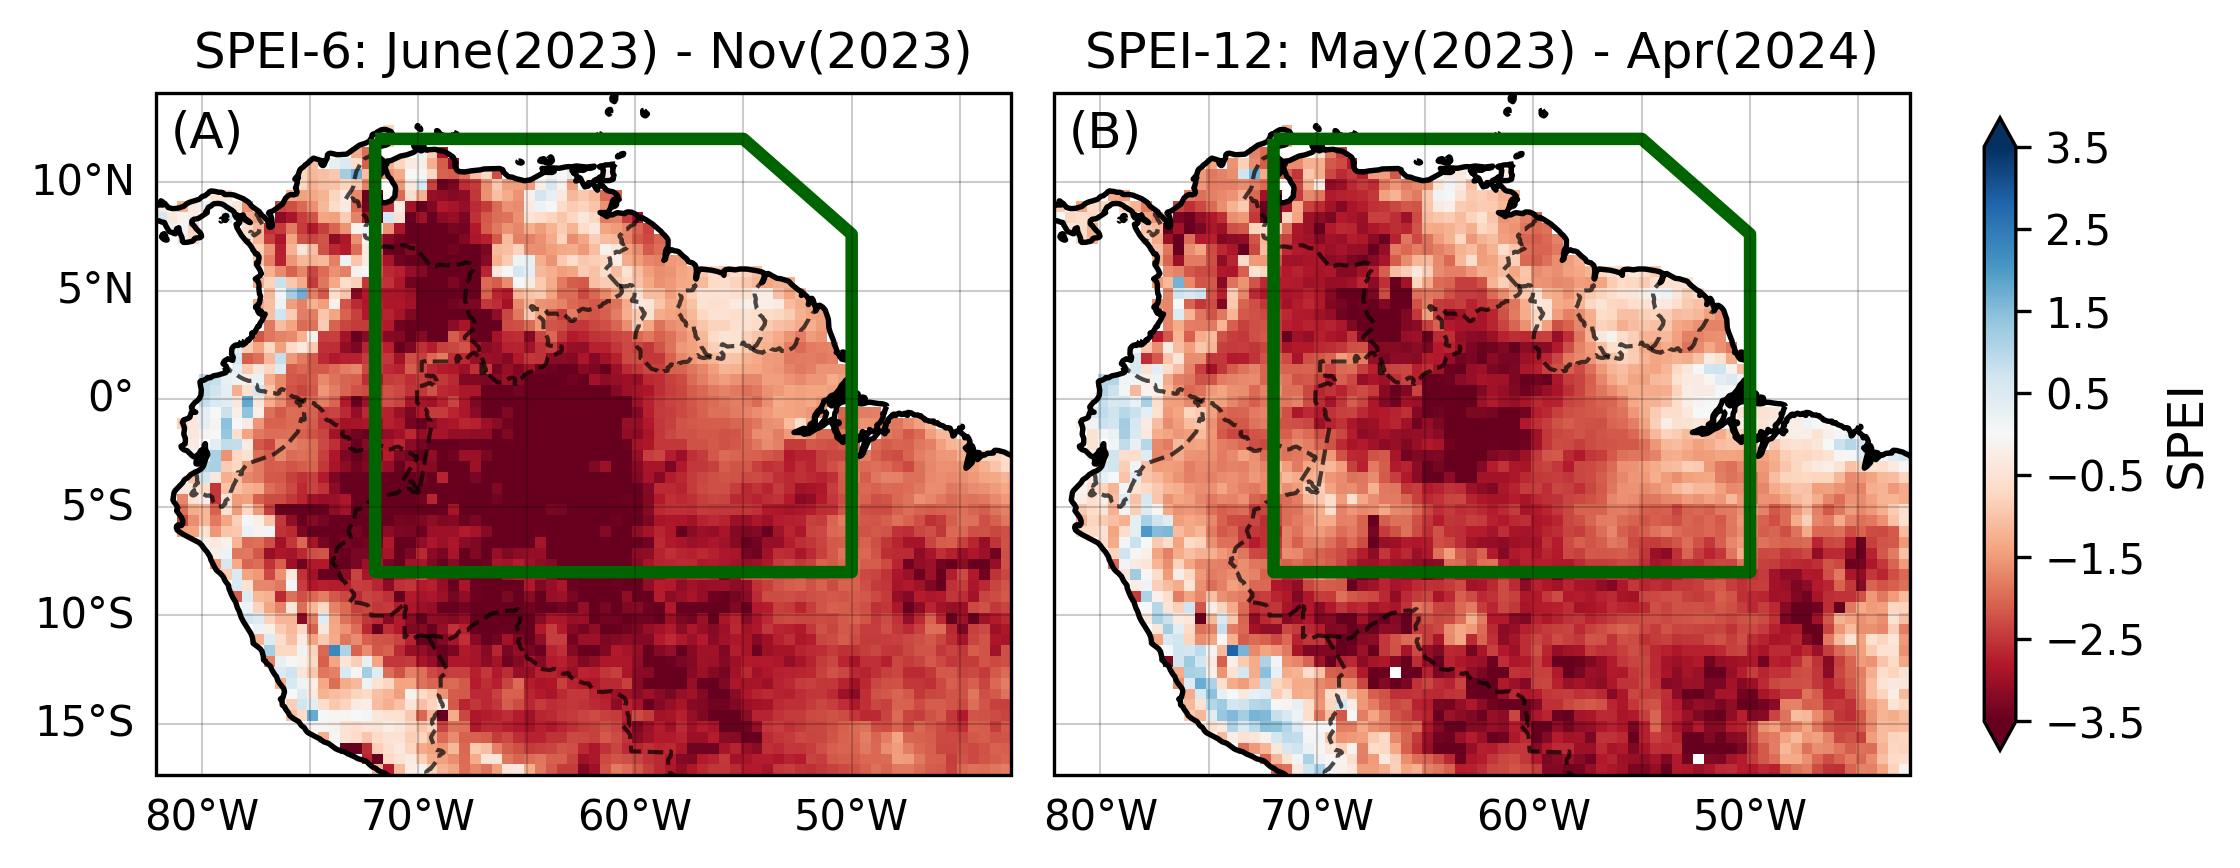

In [13]:
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (8,10), dpi = 300, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
fig.subplots_adjust(wspace=0.05)
elev_kwargs = {"cmap" : "RdBu",
               "vmin" : -3.5, 
               "vmax" : 3.5}
cbar=spei_M6_full.sel(time="2023-11-01").plot(ax=ax[0], **elev_kwargs, add_colorbar=False)
cbar=spei_M12_full.sel(time="2024-04-01").plot(ax=ax[1], **elev_kwargs, add_colorbar=False)

#cbar=spei_M6_full.sel(time="2024-06-01").plot(ax=ax[0], **elev_kwargs, add_colorbar=False)
#cbar=spei_M12_full.sel(time="2024-06-01").plot(ax=ax[1], **elev_kwargs, add_colorbar=False)
names = ["SPEI-6: June(2023) - Nov(2023)","SPEI-12: May(2023) - Apr(2024)"]
for i in np.arange(0,2,1):
    ax[i].coastlines(lw = 1.3)
    ax[i].add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--")
    sf_10.boundary.plot(ax = ax[i], lw = 3, color = "darkgreen")
    ax[i].set_title(names[i], loc = "center",fontsize=12)

glt = ax[0].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', alpha=0.2, draw_labels=True)
glt.top_labels = False
glt.right_labels = False

glt = ax[1].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', alpha=0.2, draw_labels=True)
glt.top_labels = False
glt.right_labels = False
glt.left_labels = False


cbar = plt.colorbar(cbar, ax = ax, location = "right", fraction = 0.017, pad = 0.04, extend = "both")
cbar.set_label(label = "SPEI",fontsize=12)
num_ticks = 8  # Change this number to increase/decrease the number of ticks
cbar.set_ticks(np.linspace(cbar.vmin, cbar.vmax, num_ticks))

# Add subplot labels
labels = ['(A)', '(B)']
for i, axes in enumerate(ax.flat):
    axes.annotate(labels[i], xy=(0.06, 0.94), xycoords='axes fraction',
                  fontsize=12, ha='center', va='center')

In [14]:
spei_M6_full.sel(time="2023-11-01").mean(dim="lon").mean(dim="lat")

<xarray.DataArray 'spei' ()>
array(-2.21815263)
Coordinates:
    time     datetime64[ns] 2023-11-01

In [16]:
spei_M12_full.sel(time="2024-04-01").mean(dim="lon").mean(dim="lat")

<xarray.DataArray 'spei' ()>
array(-1.96033903)
Coordinates:
    time     datetime64[ns] 2024-04-01

### Analysis of the respective SPEI Timeseries

In [20]:
region_str = str(10)

fn_spei_M1 = dir_data + 'extended_nSPEI_HG85_cal1980_2010/spei_M1_' + region_str + '.nc'
spei_M1_raw = xr.open_dataset(fn_spei_M1)
spei_M1 = spei_M1_raw.spei
spei_M1_arr = spei_M1.to_numpy()
time_spei_M1_arr = spei_M1.time.to_numpy()
spei_M1_arr_pos = spei_M1_arr>=0
spei_M1_arr_neg = spei_M1_arr<=0

fn_spei_M6 = dir_data + 'extended_nSPEI_HG85_cal1980_2010/spei_M6_' + region_str + '.nc'
spei_M6_raw = xr.open_dataset(fn_spei_M6)
spei_M6 = spei_M6_raw.spei
spei_M6_arr = spei_M6.to_numpy()
time_spei_M6_arr = spei_M6.time.to_numpy()
spei_M6_arr_pos = spei_M6_arr>=0
spei_M6_arr_neg = spei_M6_arr<=0

fn_spei_M12 = dir_data + 'extended_nSPEI_HG85_cal1980_2010/spei_M12_' + region_str + '.nc'
spei_M12_raw = xr.open_dataset(fn_spei_M12)
spei_M12 = spei_M12_raw.spei
spei_M12_arr = spei_M12.to_numpy()
time_spei_M12_arr = spei_M12.time.to_numpy()
spei_M12_arr_pos = spei_M12_arr>=0
spei_M12_arr_neg = spei_M12_arr<=0

### Plot the results

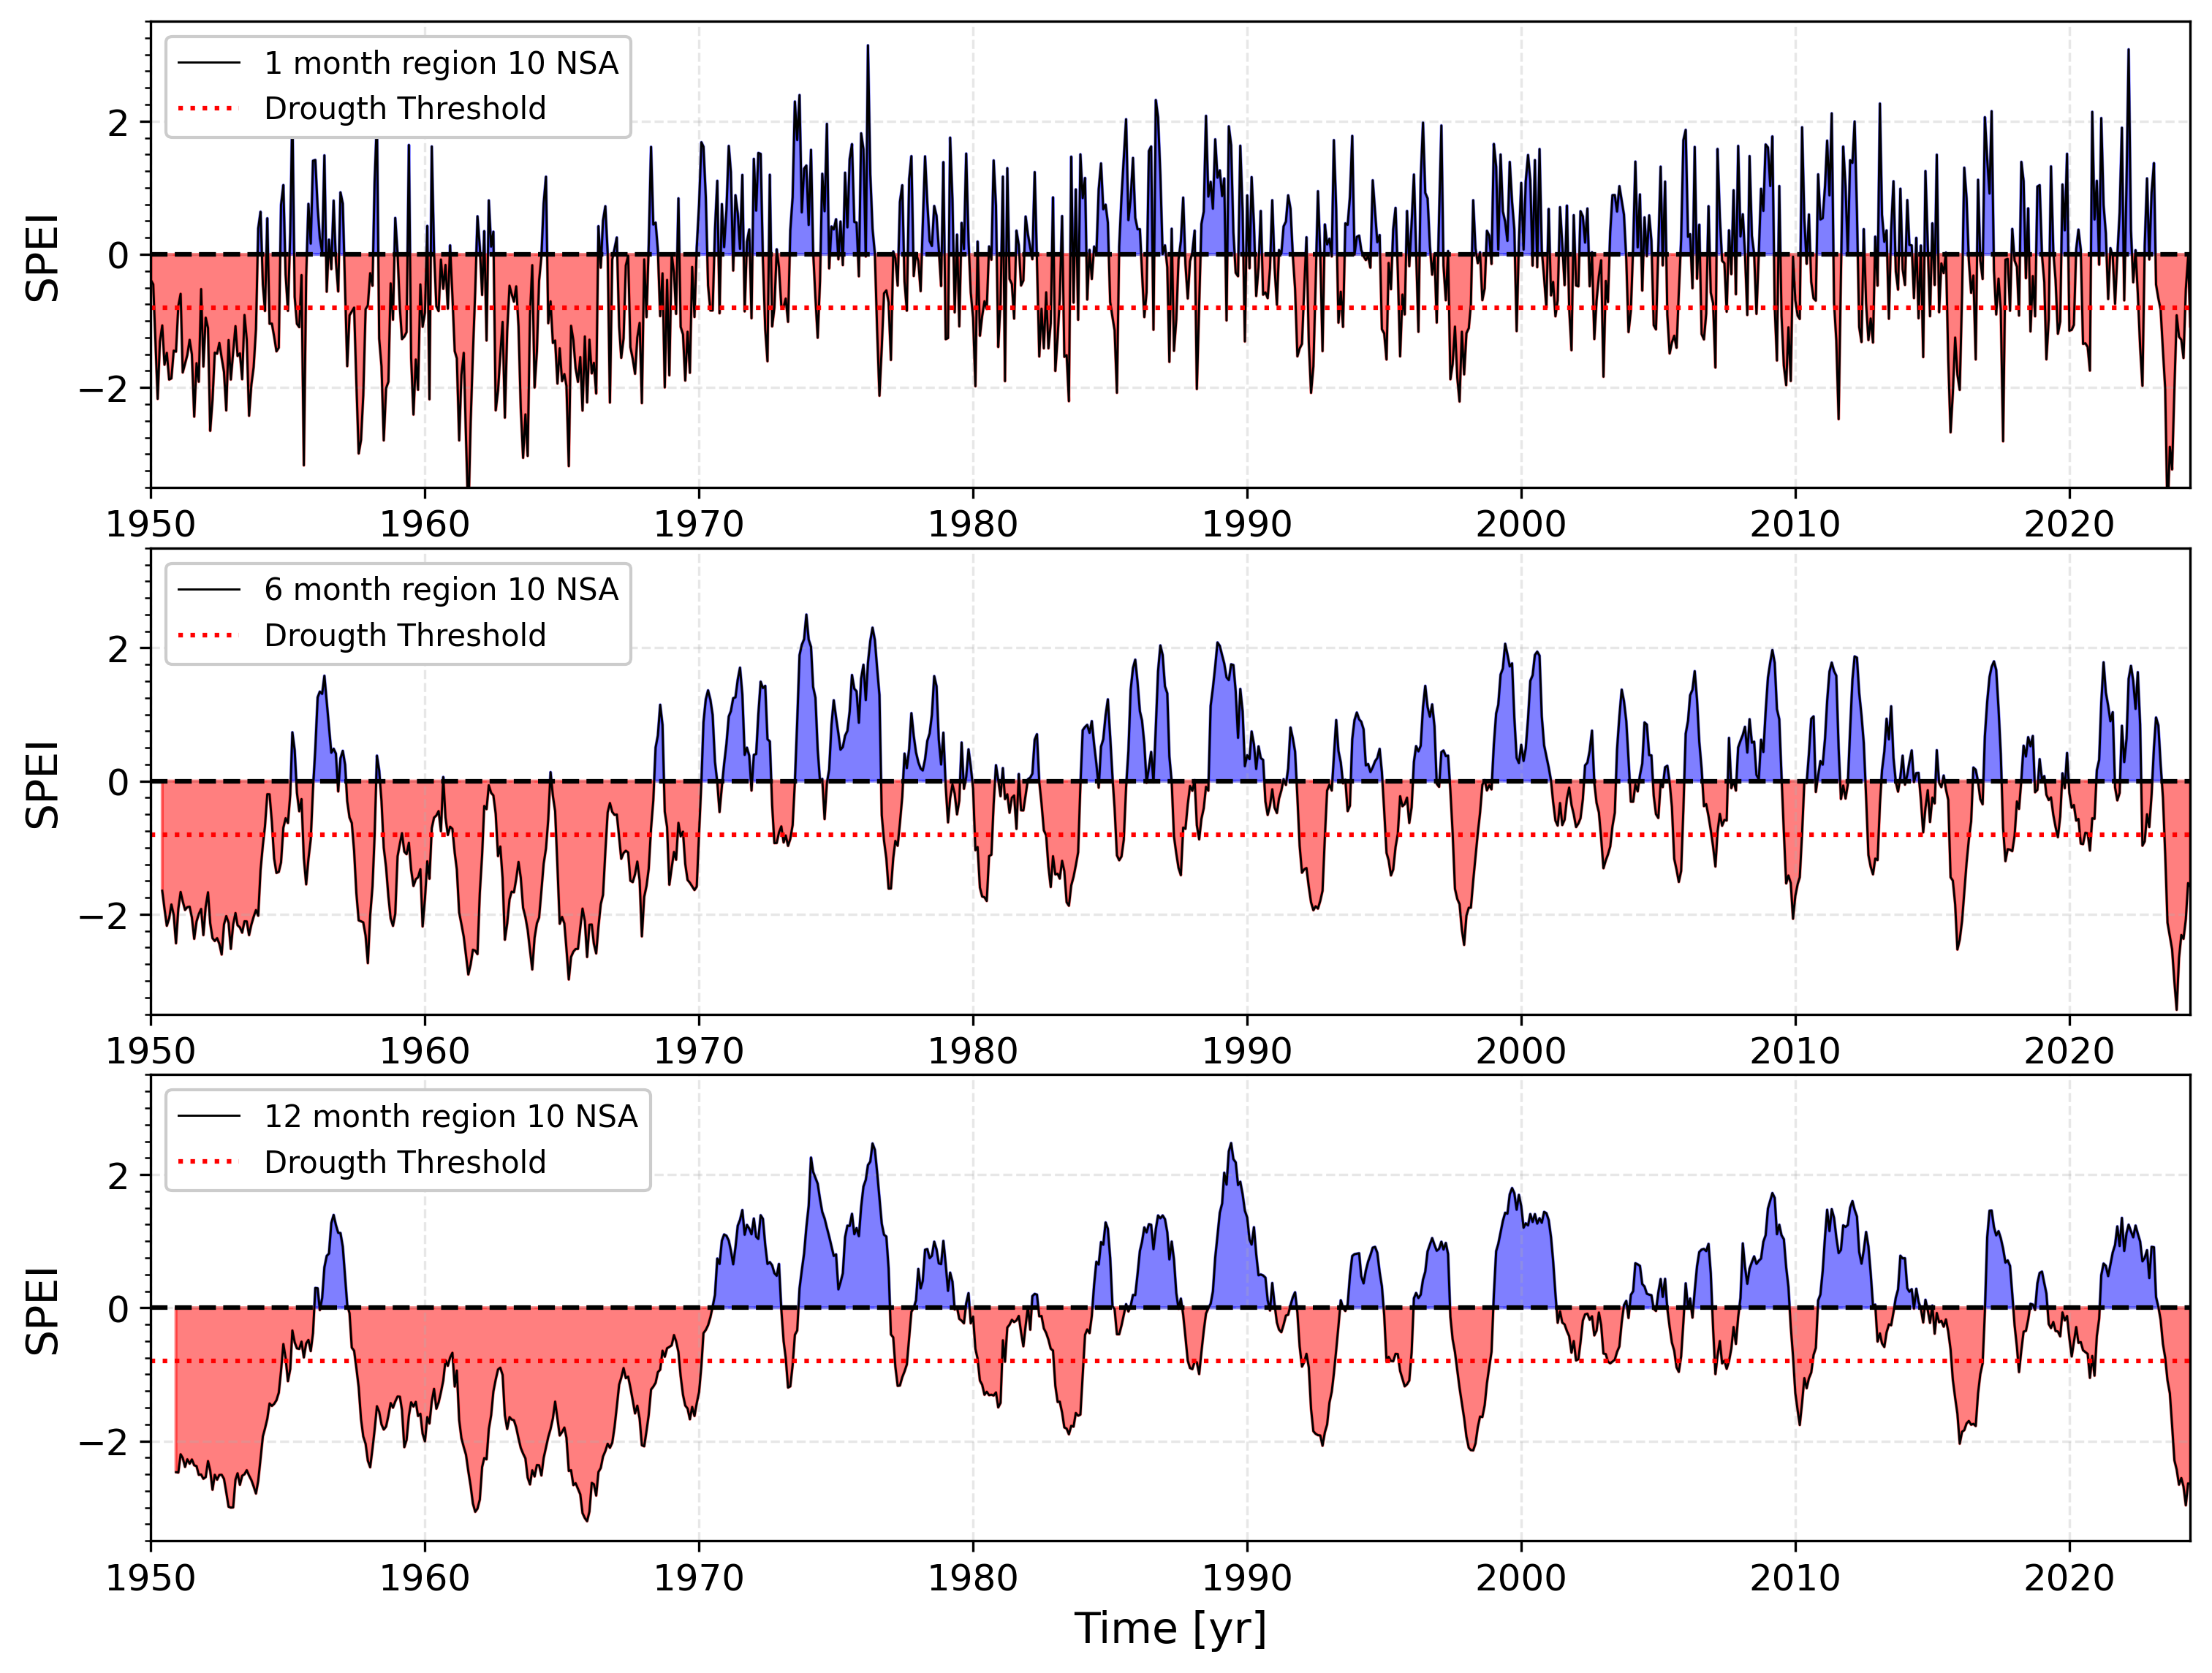

In [22]:
spei_M1_plt = spei_M1_arr
time_spei_M1_plt = time_spei_M1_arr

spei_M6_plt = spei_M6_arr
time_spei_M6_plt = time_spei_M6_arr

spei_M12_plt = spei_M12_arr
time_spei_M12_plt = time_spei_M12_arr

fig, ax = plt.subplots(ncols = 1, nrows = 3,figsize=(12,9),dpi = 300)
fig.subplots_adjust(hspace=0.13)

fn_label_1 = "1 month region " + region_str +" "+ "NSA"
ax[0].plot(time_spei_M1_plt,spei_M1_plt,label=fn_label_1, color='black',lw=0.7)
ax[0].fill_between(time_spei_M1_plt,0,spei_M1_plt,where=spei_M1_plt>=0,color='b',alpha=0.5,interpolate=True)
ax[0].fill_between(time_spei_M1_plt,0,spei_M1_plt,where=spei_M1_plt<=0,color='r',alpha=0.5,interpolate=True)
ax[0].axhline(-0.8,c="red", ls="dotted",label=r'Drougth Threshold')

fn_label_2 = "6 month region " + region_str +" "+ "NSA"
ax[1].plot(time_spei_M6_plt,spei_M6_plt,label=fn_label_2, color='black',lw=0.7)
ax[1].fill_between(time_spei_M6_plt,0,spei_M6_plt,where=spei_M6_plt>=0,color='b',alpha=0.5,interpolate=True)
ax[1].fill_between(time_spei_M6_plt,0,spei_M6_plt,where=spei_M6_plt<=0,color='r',alpha=0.5,interpolate=True)
ax[1].axhline(-0.8,c="red", ls="dotted",label=r'Drougth Threshold')

fn_label_3 = "12 month region " + region_str +" "+ "NSA"
ax[2].plot(time_spei_M12_plt,spei_M12_plt,label=fn_label_3, color='black',lw=0.7)
ax[2].fill_between(time_spei_M12_plt,0,spei_M12_plt,where=spei_M12_plt>=0,color='b',alpha=0.5,interpolate=True)
ax[2].fill_between(time_spei_M12_plt,0,spei_M12_plt,where=spei_M12_plt<=0,color='r',alpha=0.5,interpolate=True)
ax[2].axhline(-0.8,c="red", ls="dotted",label=r'Drougth Threshold')

for i in np.arange(0,3):
    ax[i].set_ylim((-3.5,3.5))
    ax[i].set_xlim((time_spei_M1_plt[0], time_spei_M1_plt[len(time_spei_M1_plt)-1]))
    ax[i].axhline(0,c="black", ls="dashed")
    legend = ax[i].legend(loc="upper left",fontsize='10')
    legend.get_frame().set_alpha(0.5)
    legend.get_frame().set_alpha(None)
    ax[i].yaxis.set_minor_locator(MultipleLocator(0.25))# defines setting of the small ticks
    ax[i].set_xlabel(r'Time [yr]',fontsize='14')
    ax[i].set_ylabel(r'SPEI',fontsize='14')
    ax[i].tick_params(axis='both', which='major', labelsize='12')
    ax[i].grid(True,alpha=0.3,linestyle = 'dashed')

### Determine the drought characteristics

In [25]:
#Determine the Duration-Severity Pairs

#Start for drought from the beginning of 2022 onwards
fn_time = "2022"
spei_arr = spei_M1_arr
time_arr = time_spei_M1_arr
M1_D_event, M1_S_event, M1_time_start, M1_time_end = get_SPEIandTime_Duration_and_Severity_RunTheory(spei_arr[time_arr>np.datetime64(fn_time)],time_arr[time_arr>np.datetime64(fn_time)])
print(M1_D_event)
print(M1_S_event)
print(np.datetime_as_string(M1_time_start))
print(np.datetime_as_string((M1_time_end)))

[ 2 11]
[ 3.36182146 21.34924771]
['2022-08-01T00:00:00.000000000' '2023-05-01T00:00:00.000000000']
['2022-10-01T00:00:00.000000000' '2024-04-01T00:00:00.000000000']


In [27]:
#determine which event is the analysed drought event
index = 1

M1_D_event_1 = M1_D_event[index]
print(M1_D_event_1)
M1_S_event_1 = M1_S_event[index]
print(M1_S_event_1)
print(np.datetime_as_string(M1_time_start[index]))
print(np.datetime_as_string(M1_time_end[index]))

11
21.34924770601133
2023-05-01T00:00:00.000000000
2024-04-01T00:00:00.000000000


In [28]:
#Determine the Pairs

spei_arr = spei_M6_arr
time_arr = time_spei_M6_arr
M6_D_event, M6_S_event, M6_time_start, M6_time_end = get_SPEIandTime_Duration_and_Severity_RunTheory(spei_arr[time_arr>np.datetime64(fn_time)],time_arr[time_arr>np.datetime64(fn_time)])
print(M6_D_event)
print(M6_S_event)
print(np.datetime_as_string(M6_time_start))
print(np.datetime_as_string((M6_time_end)))

[ 2 12]
[ 1.87689589 27.06559516]
['2022-09-01T00:00:00.000000000' '2023-07-01T00:00:00.000000000']
['2022-11-01T00:00:00.000000000' '2024-06-01T00:00:00.000000000']


In [29]:
#determine which event is the analysed drought event
index = 1

M6_D_event_1 = M6_D_event[index]
print(M6_D_event_1)
M6_S_event_1 = M6_S_event[index]
print(M6_S_event_1)
print(np.datetime_as_string(M6_time_start[index]))
print(np.datetime_as_string(M6_time_end[index]))

12
27.06559516233432
2023-07-01T00:00:00.000000000
2024-06-01T00:00:00.000000000


In [31]:
#determine the Pairs

spei_arr = spei_M12_arr
time_arr = time_spei_M12_arr
M12_D_event, M12_S_event, M12_time_start, M12_time_end = get_SPEIandTime_Duration_and_Severity_RunTheory(spei_arr[time_arr>np.datetime64(fn_time)],time_arr[time_arr>np.datetime64(fn_time)])
print(M12_D_event)
print(M12_S_event)
print(np.datetime_as_string(M12_time_start))
print(np.datetime_as_string((M12_time_end)))

[11]
[25.01600412]
['2023-08-01T00:00:00.000000000']
['2024-06-01T00:00:00.000000000']


In [32]:
#determine which event is the analysed drought event
index = 0

M12_D_event_1 = M12_D_event[index]
print(M12_D_event_1)
M12_S_event_1 = M12_S_event[index]
print(M12_S_event_1)
print(np.datetime_as_string(M12_time_start[index])) #Carefull here, alg doesn't work if only half event there
print(np.datetime_as_string(M12_time_end[index]))

11
25.01600412400198
2023-08-01T00:00:00.000000000
2024-06-01T00:00:00.000000000


## Visualise the SDF-curves for the three aggregation periods

### M1

An Event with Duration: 11 and Severity: 21.34924770601133 has a return period of: 50.525480985889914


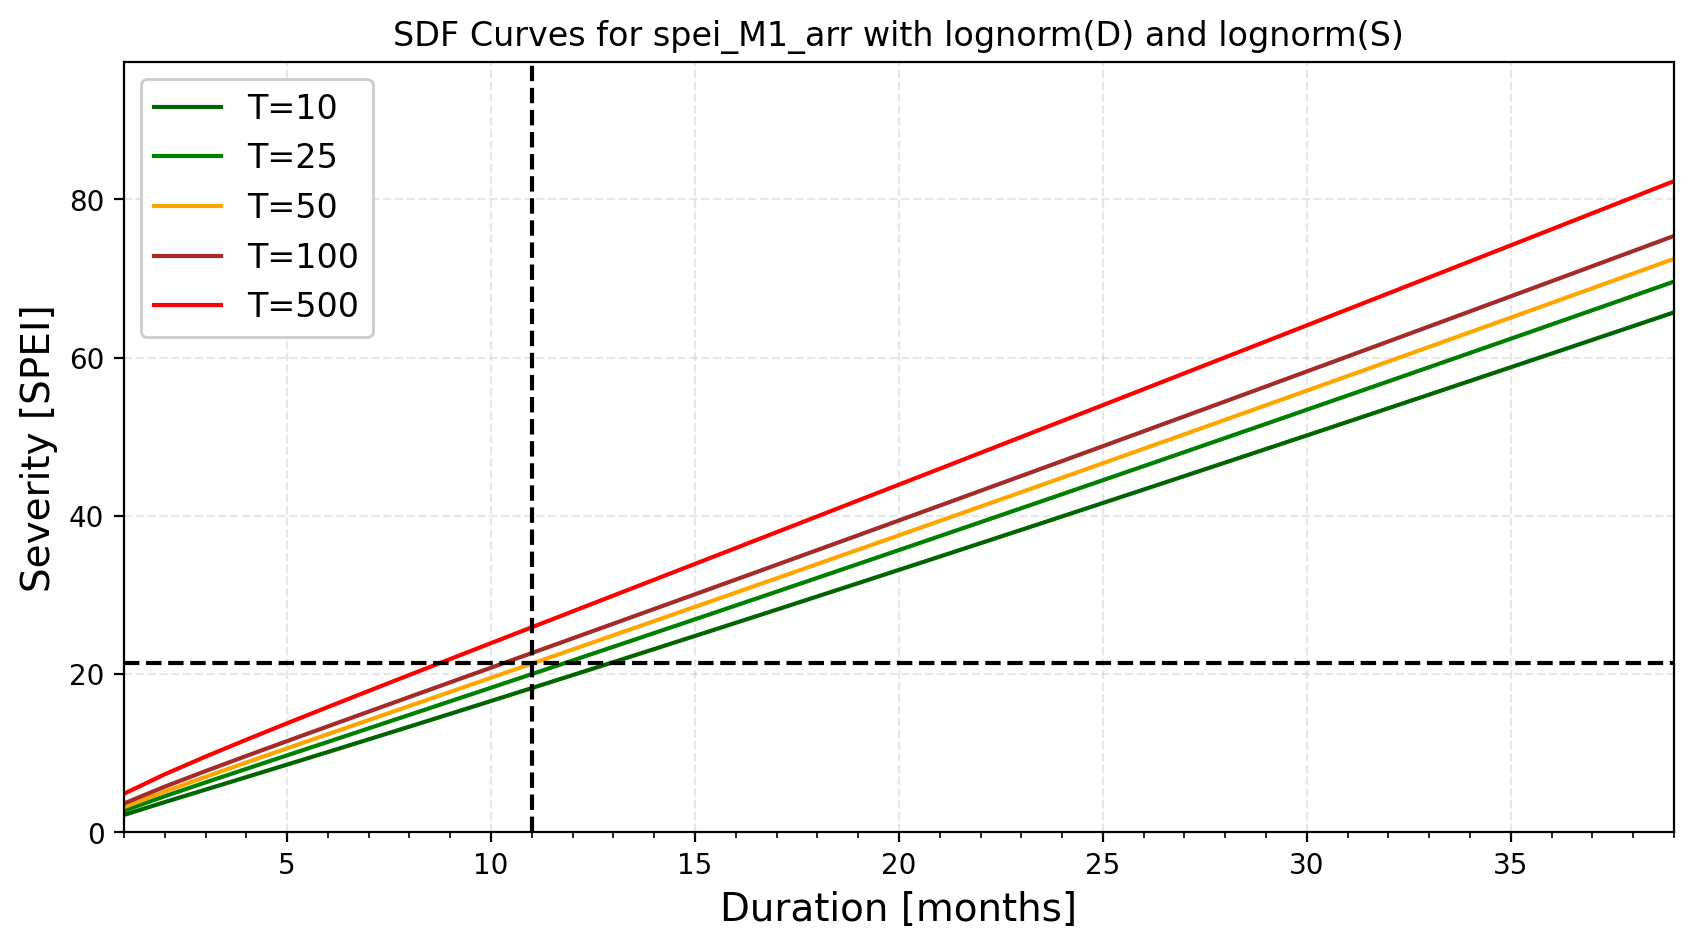

In [32]:
#Define the array for calcultion
index = spei_M1_arr
index_name = 'spei_M1_arr'
time_arr = time_spei_M1_arr

D_event = M1_D_event_1
S_event = M1_S_event_1

distr_D = stats.lognorm
distr_S = stats.lognorm

#Calculating the Pairs
D_spei_histnat, S_spei_histnat = get_SPEI_Duration_and_Severity_RunTheory(index)

#Creating pd.array      
Duration = pd.Series(D_spei_histnat, name='Duration')
Severity = pd.Series(S_spei_histnat, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)

#Fitting D
param_D = distr_D.fit(D_S_array['Duration'],floc=0)
if distr_D.name == 'lognorm':
    fitted_D = sk_uni.lognorm.fit(D_S_array['Duration'],param_D)
if distr_D.name == 'gamma':
    fitted_D = sk_uni.gamma.fit(D_S_array['Duration'],param_D)
#Fitting S
param_S = distr_S.fit(D_S_array['Severity'],floc=0)
if distr_S.name == 'lognorm':
    fitted_S = sk_uni.lognorm.fit(D_S_array['Severity'],param_S)

marg_dist_histnat={0:fitted_D,1:fitted_S}

#To prevent warnings of "overflow encountered in power"
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fitted_copula_gumble = gumbel_copula.fit(
        data=D_S_array, method='mle',
        univariate_fitter_options={'significant': False}, show_progress=False,mdists=marg_dist_histnat)

#Calculate SDF-Curves!!!!!!!!!!!!!!
#Calculated Return Periods
return_T = np.array([10,25,50,100,500])
#Length of array
n = len(D_S_array['Severity'])
#Timeperiod under consideration
diff = time_arr[-1] - time_arr[0] #!!!!CAREFULL HERE!!!!!
N=diff.astype('timedelta64[Y]').astype('int')+1 #As it round offs but actually it should round up if it 29.9 years
#Define till which month should be plotted -1
dur_treshold = max(D_S_array['Duration'])+7
#Set up array to safe results
sev_M1_histnat = np.zeros((len(return_T), len(np.arange(1,dur_treshold,1))))
for T in np.arange(0,len(return_T),1):
    return_Time = return_T[T]
    #calc return
    r = 1 - N / (n * return_Time)
    #give Duration range
    dur_M1_histnat = np.arange(1,dur_treshold,1)
    #calc fitted univariate duration curve
    u1 = fitted_copula_gumble.mdists[0].cdf(dur_M1_histnat)
    #load gumble fitting parameters !!!! Change here if other Copula is used but also equation below
    copula_para = fitted_copula_gumble.copula_params
    #Create Temporay value for severity
    v = np.zeros(len(u1))
    #Solve conditional gumble equation for all duration values for severity !!!! Change here if other Copula is used
    for j in np.arange(0,len(u1),1):
        def cond_gumbel(x):
            D_cdf = u1[j]
            return 1/D_cdf * np.exp(-(((-np.log(D_cdf))**copula_para.theta)+(-np.log(x))**copula_para.theta)**(1/copula_para.theta))*(1+((-np.log(x))/(-np.log(D_cdf)))**copula_para.theta)**(-1+(1/copula_para.theta))-r
        #V = fsolve(cond_gumbel,u1[j]) -> uses other algorithm than Matlab...
        V_root = optimize.root(cond_gumbel,u1[j],method='lm').x
        v[j] = V_root[0]
    #get the final severity values through the inverse cdf function
    sev_M1_histnat[T] = fitted_copula_gumble.mdists[1].ppf(v)

#Plot Results
fig, ax = plt.subplots(figsize=(10,5),dpi = 200)
ax.plot(dur_M1_histnat, sev_M1_histnat[0], color='darkgreen',label=r'T=10')
ax.plot(dur_M1_histnat, sev_M1_histnat[1], color='g',label=r'T=25')
ax.plot(dur_M1_histnat, sev_M1_histnat[2], color='orange',label=r'T=50')
ax.plot(dur_M1_histnat, sev_M1_histnat[3], color='brown',label=r'T=100')
ax.plot(dur_M1_histnat, sev_M1_histnat[4], color='red',label=r'T=500')
ax.set_xlim(1, dur_treshold-1)
ax.set_ylim(0,sev_M1_histnat[4][-1]+15)
ax.axvline(D_event,c="black", ls="dashed")
ax.axhline(S_event,c="black", ls="dashed")
ax.xaxis.set_minor_locator(MultipleLocator(1))# defines setting of the small ticks
#ax.yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
legend = plt.legend(loc="upper left",fontsize='12')
legend.get_frame().set_alpha(0.5)
legend.get_frame().set_alpha(None)
title_str = "SDF Curves for {} with {}(D) and {}(S)".format(index_name,fitted_D.name,fitted_S.name)
ax.set_title(title_str)
ax.set_xlabel(r'Duration [months]',fontsize='14')
ax.set_ylabel(r'Severity [SPEI]',fontsize='14')
ax.tick_params(axis='both', which='major', labelsize='10')
ax.grid(True,alpha=0.3,linestyle = 'dashed')

D_event_returnT = float(D_event)
S_event_returnT = float(S_event)
u1 = fitted_copula_gumble.mdists[0].cdf(D_event_returnT)
v1 = fitted_copula_gumble.mdists[1].cdf(S_event_returnT)    
def cond_gumbel_T(x):
    C = 1/u1 * np.exp(-(((-np.log(u1))**copula_para.theta)+(-np.log(v1))**copula_para.theta)**(1/copula_para.theta))*(1+((-np.log(v1))/(-np.log(u1)))**copula_para.theta)**(-1+(1/copula_para.theta))
    return (N / (n *(1 - C))) - x
return_time = optimize.root(cond_gumbel_T,u1,method='lm').x
print("An Event with Duration:",D_event,"and Severity:",S_event, "has a return period of:",return_time[0]  )

An Event with Duration: 12 and Severity: 27.06559516233432 has a return period of: 171.19584596350123


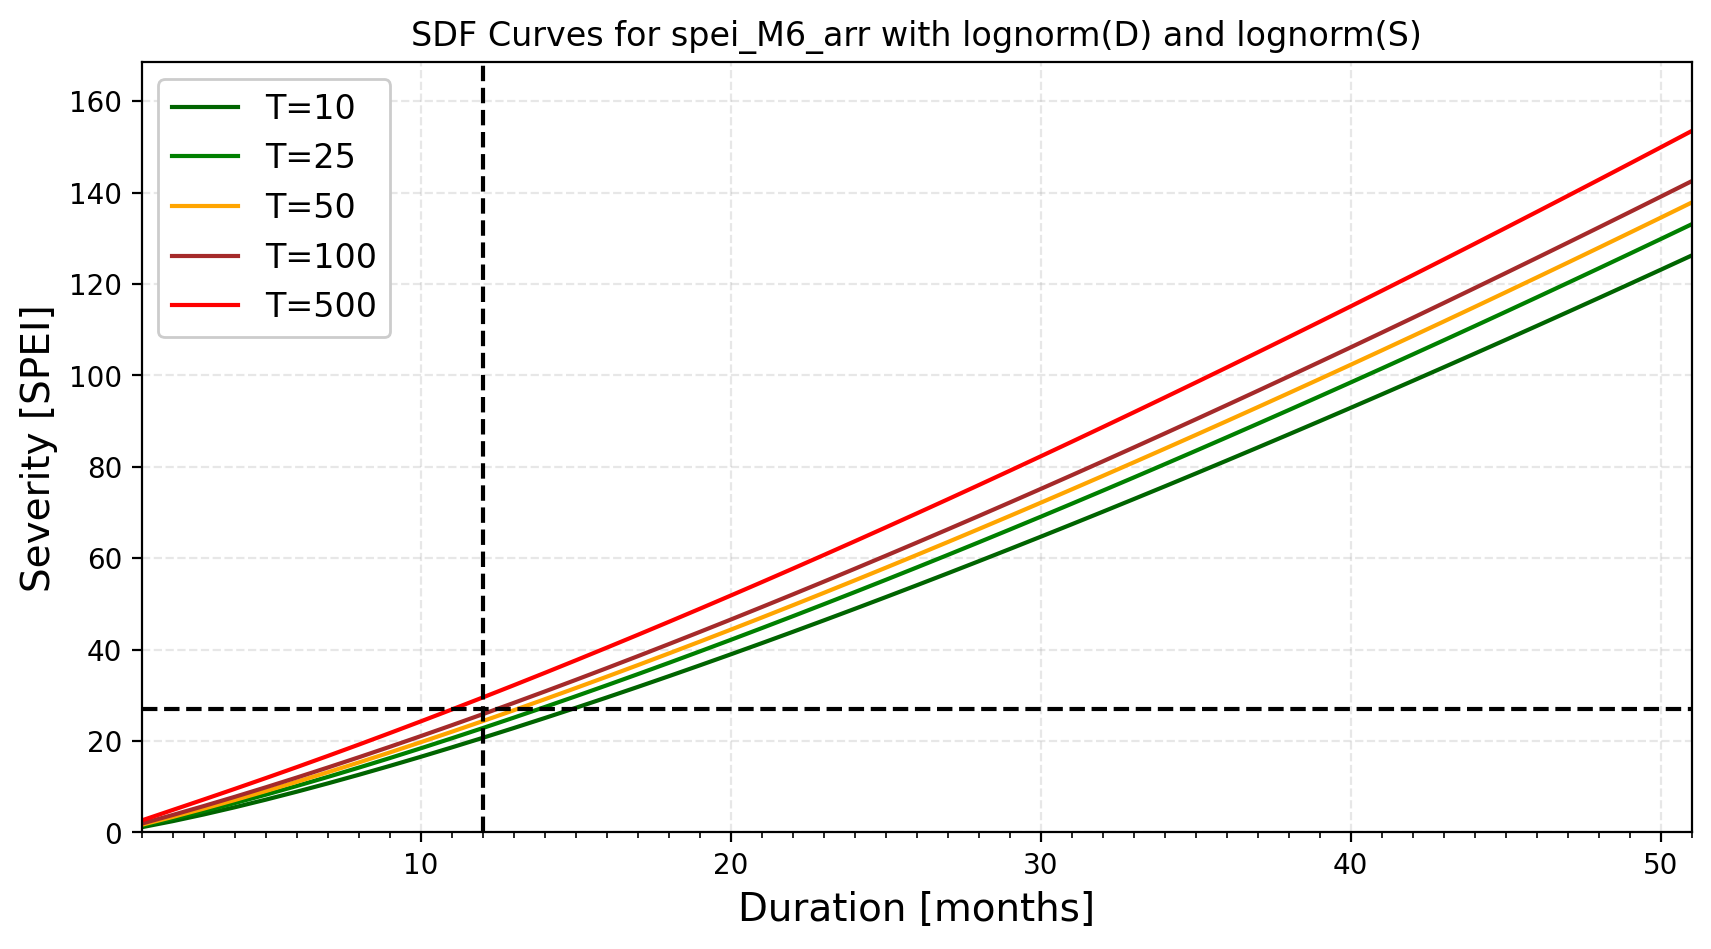

In [33]:
#Define the array for calcultion
index = spei_M6_arr
index_name = 'spei_M6_arr'
time_arr = time_spei_M6_arr

D_event = M6_D_event_1
S_event = M6_S_event_1

distr_D = stats.lognorm
distr_S = stats.lognorm

#Calculating the Pairs
D_spei_histnat, S_spei_histnat = get_SPEI_Duration_and_Severity_RunTheory(index)

#Creating pd.array      
Duration = pd.Series(D_spei_histnat, name='Duration')
Severity = pd.Series(S_spei_histnat, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)

#Fitting D
param_D = distr_D.fit(D_S_array['Duration'],floc=0)
if distr_D.name == 'lognorm':
    fitted_D = sk_uni.lognorm.fit(D_S_array['Duration'],param_D)
if distr_D.name == 'gamma':
    fitted_D = sk_uni.gamma.fit(D_S_array['Duration'],param_D)
#Fitting S
param_S = distr_S.fit(D_S_array['Severity'],floc=0)
if distr_S.name == 'lognorm':
    fitted_S = sk_uni.lognorm.fit(D_S_array['Severity'],param_S)

marg_dist_histnat={0:fitted_D,1:fitted_S}

#To prevent warnings of "overflow encountered in power"
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fitted_copula_gumble = gumbel_copula.fit(
        data=D_S_array, method='mle',
        univariate_fitter_options={'significant': False}, show_progress=False,mdists=marg_dist_histnat)

#Calculate SDF-Curves!!!!!!!!!!!!!!
#Calculated Return Periods
return_T = np.array([10,25,50,100,500])
#Length of array
n = len(D_S_array['Severity'])
#Timeperiod under consideration
diff = time_arr[-1] - time_arr[0] #!!!!CAREFULL HERE!!!!!
N=diff.astype('timedelta64[Y]').astype('int')+1 #As it round offs but actually it should round up if it 29.9 years
#Define till which month should be plotted -1
dur_treshold = max(D_S_array['Duration'])+7
#Set up array to safe results
sev_M1_histnat = np.zeros((len(return_T), len(np.arange(1,dur_treshold,1))))
for T in np.arange(0,len(return_T),1):
    return_Time = return_T[T]
    #calc return
    r = 1 - N / (n * return_Time)
    #give Duration range
    dur_M1_histnat = np.arange(1,dur_treshold,1)
    #calc fitted univariate duration curve
    u1 = fitted_copula_gumble.mdists[0].cdf(dur_M1_histnat)
    #load gumble fitting parameters !!!! Change here if other Copula is used but also equation below
    copula_para = fitted_copula_gumble.copula_params
    #Create Temporay value for severity
    v = np.zeros(len(u1))
    #Solve conditional gumble equation for all duration values for severity !!!! Change here if other Copula is used
    for j in np.arange(0,len(u1),1):
        def cond_gumbel(x):
            D_cdf = u1[j]
            return 1/D_cdf * np.exp(-(((-np.log(D_cdf))**copula_para.theta)+(-np.log(x))**copula_para.theta)**(1/copula_para.theta))*(1+((-np.log(x))/(-np.log(D_cdf)))**copula_para.theta)**(-1+(1/copula_para.theta))-r
        #V = fsolve(cond_gumbel,u1[j]) -> uses other algorithm than Matlab...
        V_root = optimize.root(cond_gumbel,u1[j],method='lm').x
        v[j] = V_root[0]
    #get the final severity values through the inverse cdf function
    sev_M1_histnat[T] = fitted_copula_gumble.mdists[1].ppf(v)

#Plot Results
fig, ax = plt.subplots(figsize=(10,5),dpi = 200)
ax.plot(dur_M1_histnat, sev_M1_histnat[0], color='darkgreen',label=r'T=10')
ax.plot(dur_M1_histnat, sev_M1_histnat[1], color='g',label=r'T=25')
ax.plot(dur_M1_histnat, sev_M1_histnat[2], color='orange',label=r'T=50')
ax.plot(dur_M1_histnat, sev_M1_histnat[3], color='brown',label=r'T=100')
ax.plot(dur_M1_histnat, sev_M1_histnat[4], color='red',label=r'T=500')
ax.set_xlim(1, dur_treshold-1)
ax.set_ylim(0,sev_M1_histnat[4][-1]+15)
ax.axvline(D_event,c="black", ls="dashed")
ax.axhline(S_event,c="black", ls="dashed")
ax.xaxis.set_minor_locator(MultipleLocator(1))# defines setting of the small ticks
#ax.yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
legend = plt.legend(loc="upper left",fontsize='12')
legend.get_frame().set_alpha(0.5)
legend.get_frame().set_alpha(None)
title_str = "SDF Curves for {} with {}(D) and {}(S)".format(index_name,fitted_D.name,fitted_S.name)
ax.set_title(title_str)
ax.set_xlabel(r'Duration [months]',fontsize='14')
ax.set_ylabel(r'Severity [SPEI]',fontsize='14')
ax.tick_params(axis='both', which='major', labelsize='10')
ax.grid(True,alpha=0.3,linestyle = 'dashed')

D_event_returnT = float(D_event)
S_event_returnT = float(S_event)
u1 = fitted_copula_gumble.mdists[0].cdf(D_event_returnT)
v1 = fitted_copula_gumble.mdists[1].cdf(S_event_returnT)    
def cond_gumbel_T(x):
    C = 1/u1 * np.exp(-(((-np.log(u1))**copula_para.theta)+(-np.log(v1))**copula_para.theta)**(1/copula_para.theta))*(1+((-np.log(v1))/(-np.log(u1)))**copula_para.theta)**(-1+(1/copula_para.theta))
    return (N / (n *(1 - C))) - x
return_time = optimize.root(cond_gumbel_T,u1,method='lm').x
print("An Event with Duration:",D_event,"and Severity:",S_event, "has a return period of:",return_time[0]  )

An Event with Duration: 12 and Severity: 27.310406719025575 has a return period of: 480.6224561954698


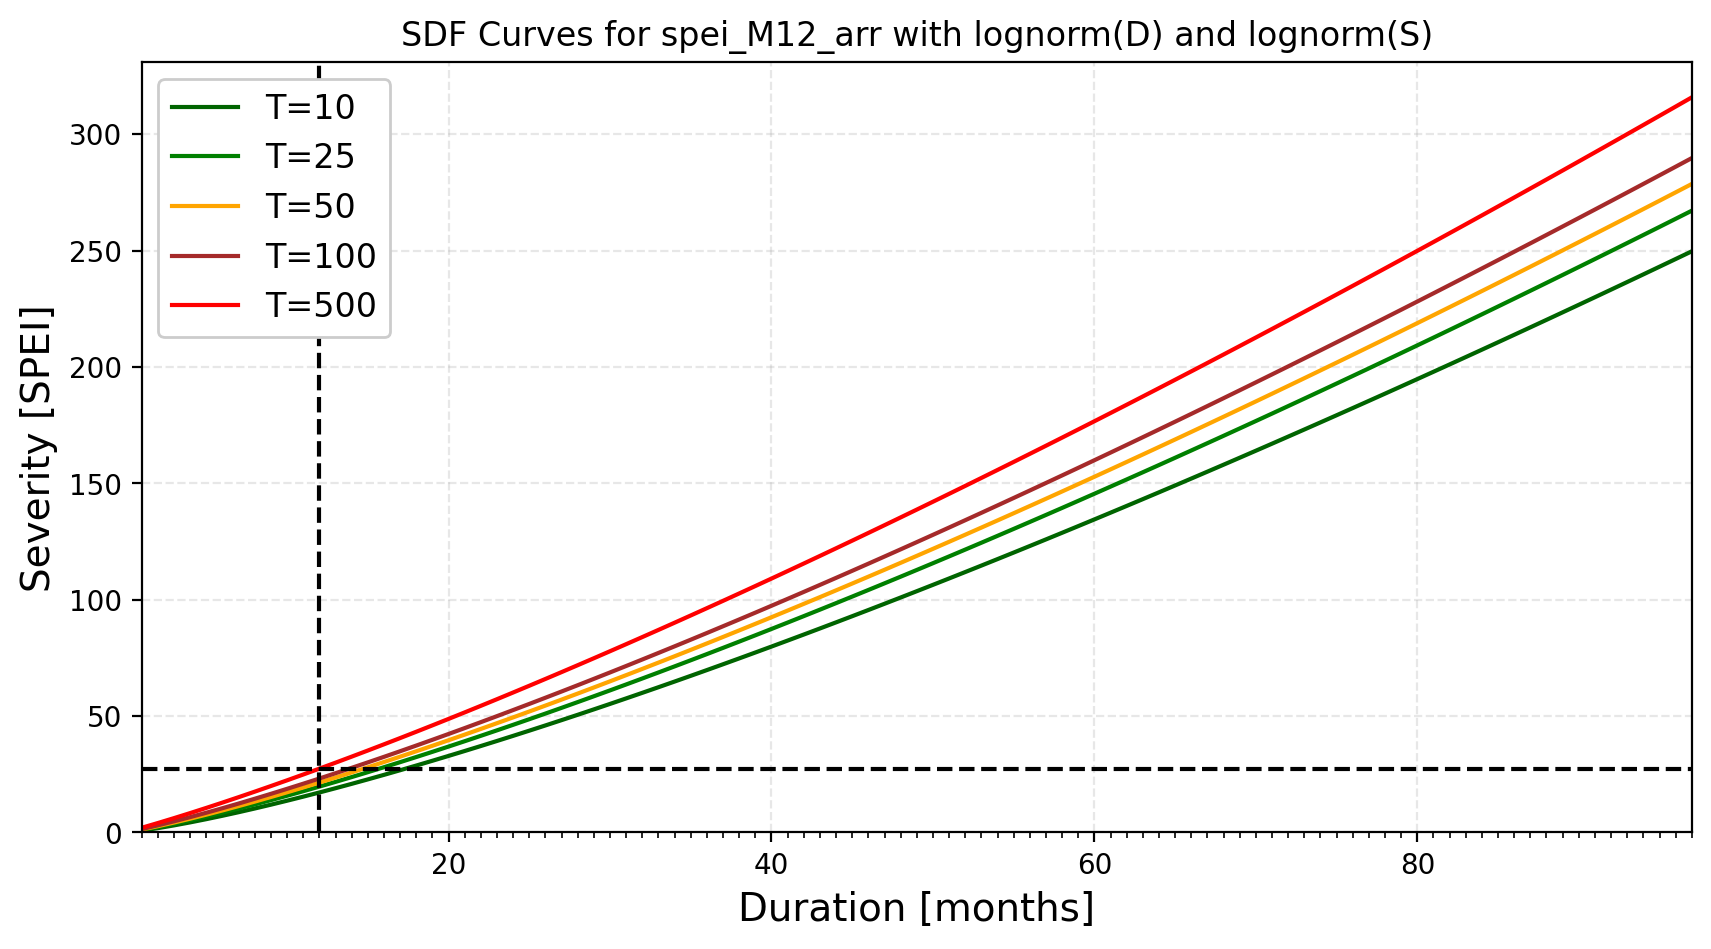

In [114]:
#Define the array for calcultion
index = spei_M12_arr
index_name = 'spei_M12_arr'
time_arr = time_spei_M12_arr

D_event = M12_D_event_1
S_event = M12_S_event_1

distr_D = stats.lognorm
distr_S = stats.lognorm

#Calculating the Pairs
D_spei_histnat, S_spei_histnat = get_SPEI_Duration_and_Severity_RunTheory(index)

#Creating pd.array      
Duration = pd.Series(D_spei_histnat, name='Duration')
Severity = pd.Series(S_spei_histnat, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)

#Fitting D
param_D = distr_D.fit(D_S_array['Duration'],floc=0)
if distr_D.name == 'lognorm':
    fitted_D = sk_uni.lognorm.fit(D_S_array['Duration'],param_D)
if distr_D.name == 'gamma':
    fitted_D = sk_uni.gamma.fit(D_S_array['Duration'],param_D)
#Fitting S
param_S = distr_S.fit(D_S_array['Severity'],floc=0)
if distr_S.name == 'lognorm':
    fitted_S = sk_uni.lognorm.fit(D_S_array['Severity'],param_S)

marg_dist_histnat={0:fitted_D,1:fitted_S}

#To prevent warnings of "overflow encountered in power"
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fitted_copula_gumble = gumbel_copula.fit(
        data=D_S_array, method='mle',
        univariate_fitter_options={'significant': False}, show_progress=False,mdists=marg_dist_histnat)

#Calculate SDF-Curves!!!!!!!!!!!!!!
#Calculated Return Periods
return_T = np.array([10,25,50,100,500])
#Length of array
n = len(D_S_array['Severity'])
#Timeperiod under consideration
diff = time_arr[-1] - time_arr[0] #!!!!CAREFULL HERE!!!!!
N=diff.astype('timedelta64[Y]').astype('int')+1 #As it round offs but actually it should round up if it 29.9 years
#Define till which month should be plotted -1
dur_treshold = max(D_S_array['Duration'])+7
#Set up array to safe results
sev_M1_histnat = np.zeros((len(return_T), len(np.arange(1,dur_treshold,1))))
for T in np.arange(0,len(return_T),1):
    return_Time = return_T[T]
    #calc return
    r = 1 - N / (n * return_Time)
    #give Duration range
    dur_M1_histnat = np.arange(1,dur_treshold,1)
    #calc fitted univariate duration curve
    u1 = fitted_copula_gumble.mdists[0].cdf(dur_M1_histnat)
    #load gumble fitting parameters !!!! Change here if other Copula is used but also equation below
    copula_para = fitted_copula_gumble.copula_params
    #Create Temporay value for severity
    v = np.zeros(len(u1))
    #Solve conditional gumble equation for all duration values for severity !!!! Change here if other Copula is used
    for j in np.arange(0,len(u1),1):
        def cond_gumbel(x):
            D_cdf = u1[j]
            return 1/D_cdf * np.exp(-(((-np.log(D_cdf))**copula_para.theta)+(-np.log(x))**copula_para.theta)**(1/copula_para.theta))*(1+((-np.log(x))/(-np.log(D_cdf)))**copula_para.theta)**(-1+(1/copula_para.theta))-r
        #V = fsolve(cond_gumbel,u1[j]) -> uses other algorithm than Matlab...
        V_root = optimize.root(cond_gumbel,u1[j],method='lm').x
        v[j] = V_root[0]
    #get the final severity values through the inverse cdf function
    sev_M1_histnat[T] = fitted_copula_gumble.mdists[1].ppf(v)

#Plot Results
fig, ax = plt.subplots(figsize=(10,5),dpi = 200)
ax.plot(dur_M1_histnat, sev_M1_histnat[0], color='darkgreen',label=r'T=10')
ax.plot(dur_M1_histnat, sev_M1_histnat[1], color='g',label=r'T=25')
ax.plot(dur_M1_histnat, sev_M1_histnat[2], color='orange',label=r'T=50')
ax.plot(dur_M1_histnat, sev_M1_histnat[3], color='brown',label=r'T=100')
ax.plot(dur_M1_histnat, sev_M1_histnat[4], color='red',label=r'T=500')
ax.set_xlim(1, dur_treshold-1)
ax.set_ylim(0,sev_M1_histnat[4][-1]+15)
ax.axvline(D_event,c="black", ls="dashed")
ax.axhline(S_event,c="black", ls="dashed")
ax.xaxis.set_minor_locator(MultipleLocator(1))# defines setting of the small ticks
#ax.yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
legend = plt.legend(loc="upper left",fontsize='12')
legend.get_frame().set_alpha(0.5)
legend.get_frame().set_alpha(None)
title_str = "SDF Curves for {} with {}(D) and {}(S)".format(index_name,fitted_D.name,fitted_S.name)
ax.set_title(title_str)
ax.set_xlabel(r'Duration [months]',fontsize='14')
ax.set_ylabel(r'Severity [SPEI]',fontsize='14')
ax.tick_params(axis='both', which='major', labelsize='10')
ax.grid(True,alpha=0.3,linestyle = 'dashed')

D_event_returnT = float(D_event)
S_event_returnT = float(S_event)
u1 = fitted_copula_gumble.mdists[0].cdf(D_event_returnT)
v1 = fitted_copula_gumble.mdists[1].cdf(S_event_returnT)    
def cond_gumbel_T(x):
    C = 1/u1 * np.exp(-(((-np.log(u1))**copula_para.theta)+(-np.log(v1))**copula_para.theta)**(1/copula_para.theta))*(1+((-np.log(v1))/(-np.log(u1)))**copula_para.theta)**(-1+(1/copula_para.theta))
    return (N / (n *(1 - C))) - x
return_time = optimize.root(cond_gumbel_T,u1,method='lm').x
print("An Event with Duration:",D_event,"and Severity:",S_event, "has a return period of:",return_time[0]  )